# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

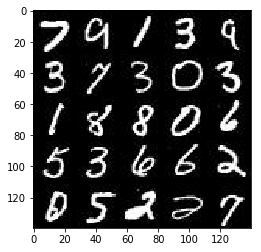

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

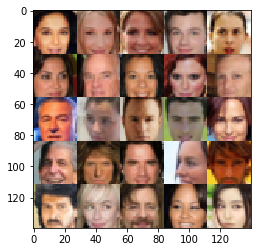

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_shape = (None, image_width, image_height, image_channels)
    # TODO: Implement Function
    real_inputs   = tf.placeholder(tf.float32, shape=real_shape,    name='real_inputs')
    z_inputs      = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, shape=(None),        name='learning_rate')
    
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
import numpy as np

GEN_SCOPE    = 'generator'
DISC_SCOPE   = 'discriminator'
ALPHA        = 0.2
FLAT_SHAPE   = (7, 7, 224)
FLAT_PRODUCT = np.prod(FLAT_SHAPE)


def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    def conv_layer(layer, filters, apply_batch_norm=True, kernel_size=5, strides=2):
        layer = tf.layers.conv2d(layer, filters, kernel_size, strides, padding='same')
        if apply_batch_norm:
            layer = tf.layers.batch_normalization(layer, training=True)
        return tf.maximum(ALPHA * layer, layer)
    def fully_connected(layer):
        shape = np.prod(layer.shape[1:]).value
        flat  = tf.reshape(layer, (-1, shape))
        return tf.layers.dense(flat, 1)

    with tf.variable_scope(DISC_SCOPE, reuse=reuse):
        layer = images
        for conv_args in [
            (56,  True),
            (112, False),
            (224, False)
        ]:
            layer = conv_layer(layer, *conv_args)
        logits = fully_connected(layer)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    def fully_connected(layer):
        layer = tf.layers.dense(z, np.prod(FLAT_SHAPE))
        return tf.reshape(layer, (-1, *FLAT_SHAPE))
    def conv_transpose_layer(layer, filters, kernel_size=5, strides=2):
        if isinstance(filters, int):
            layer = tf.layers.conv2d_transpose(layer, filters, kernel_size, strides, padding='same')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        return tf.maximum(ALPHA * layer, layer)
    
    with tf.variable_scope(GEN_SCOPE, reuse=not is_train):
        layer = fully_connected(z)
        for conv_args in [
            (None, 0, 0),
            (224,  5, 2),
        ]:
            layer = conv_transpose_layer(layer, *conv_args)
        logits = tf.layers.conv2d_transpose(layer, out_channel_dim, 5, strides=2, padding='same')
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    gen_model                         = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)

    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disc_logits_real, labels=tf.ones_like(disc_model_real)
        )
    )
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disc_logits_fake, labels=tf.zeros_like(disc_model_fake)
        )
    )
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disc_logits_fake, labels=tf.ones_like(disc_model_fake)
        )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake

    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    def is_in(scope_name, var):
        return var.name.startswith(scope_name)
    trainables = tf.trainable_variables()
    disc_vars = [var for var in trainables if is_in(DISC_SCOPE, var)]
    gen_vars  = [var for var in trainables if is_in(GEN_SCOPE, var)]
    
    # https://github.com/udacity/deep-learning/blob/master/batch-norm/Batch_Normalization_Solutions.ipynb
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        gen_train_opt  = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)

        return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
PRINT_EVERY = 10
SHOW_EVERY  = 100
SHOW_COUNT  = 9

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    def print_progress():
        train_loss_d = disc_loss.eval({z_inputs: batch_z, real_inputs: batch_images})
        train_loss_g = gen_loss.eval({z_inputs: batch_z})
        
        print("Epoch {}/{}...".format(epoch_i + 1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))
    def show_progress():
        show_generator_output(sess, SHOW_COUNT, z_inputs, out_channel_dim, data_image_mode)
    def generate_noise():
        return np.random.uniform(-1, 1, size=(batch_size, z_dim))
        
    out_channel_dim          = data_shape[-1]
    real_inputs, z_inputs, _ = model_inputs(*data_shape[1:], z_dim)
    disc_loss, gen_loss      = model_loss(real_inputs, z_inputs, out_channel_dim)
    disc_opt,  gen_opt       = model_opt(disc_loss, gen_loss, learning_rate, beta1)

    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    step     = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = batch_images * 2.0 # NOTE: Normalizes image ranges
                batch_z      = generate_noise()

                sess.run(disc_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z})
                sess.run(gen_opt,  feed_dict={real_inputs: batch_images, z_inputs: batch_z})

                if step % PRINT_EVERY == 0:
                    print_progress()
                if step % SHOW_EVERY == 0:
                    show_progress()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8030... Generator Loss: 0.8951
Epoch 1/2... Discriminator Loss: 0.0974... Generator Loss: 2.6773
Epoch 1/2... Discriminator Loss: 0.0695... Generator Loss: 3.4493
Epoch 1/2... Discriminator Loss: 0.0614... Generator Loss: 4.8780
Epoch 1/2... Discriminator Loss: 0.3985... Generator Loss: 5.4774
Epoch 1/2... Discriminator Loss: 4.7673... Generator Loss: 0.0134
Epoch 1/2... Discriminator Loss: 0.5520... Generator Loss: 1.5889
Epoch 1/2... Discriminator Loss: 0.8780... Generator Loss: 1.4320
Epoch 1/2... Discriminator Loss: 0.9448... Generator Loss: 1.9859
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 1.0981


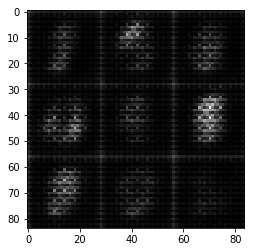

Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 1.1492
Epoch 1/2... Discriminator Loss: 0.7241... Generator Loss: 1.3726
Epoch 1/2... Discriminator Loss: 0.6843... Generator Loss: 1.3127
Epoch 1/2... Discriminator Loss: 0.3760... Generator Loss: 2.0669
Epoch 1/2... Discriminator Loss: 0.7482... Generator Loss: 1.9913
Epoch 1/2... Discriminator Loss: 0.6655... Generator Loss: 2.3057
Epoch 1/2... Discriminator Loss: 0.7936... Generator Loss: 1.5968
Epoch 1/2... Discriminator Loss: 0.8422... Generator Loss: 1.1150
Epoch 1/2... Discriminator Loss: 0.6033... Generator Loss: 1.4056
Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 1.2811


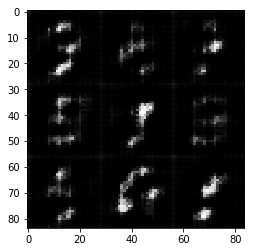

Epoch 1/2... Discriminator Loss: 1.6017... Generator Loss: 0.3514
Epoch 1/2... Discriminator Loss: 0.9896... Generator Loss: 0.8822
Epoch 1/2... Discriminator Loss: 0.8116... Generator Loss: 1.4473
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 1.6176
Epoch 1/2... Discriminator Loss: 1.0154... Generator Loss: 1.0948
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 0.9656
Epoch 1/2... Discriminator Loss: 0.9874... Generator Loss: 0.8119
Epoch 1/2... Discriminator Loss: 1.1272... Generator Loss: 0.8997
Epoch 1/2... Discriminator Loss: 0.9243... Generator Loss: 1.2592
Epoch 1/2... Discriminator Loss: 0.9951... Generator Loss: 0.7917


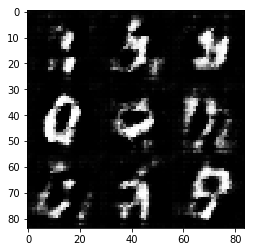

Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.5389
Epoch 1/2... Discriminator Loss: 1.0194... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 1.7251
Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 1.2909
Epoch 1/2... Discriminator Loss: 0.9532... Generator Loss: 1.4630
Epoch 1/2... Discriminator Loss: 1.0047... Generator Loss: 0.9630
Epoch 1/2... Discriminator Loss: 0.9979... Generator Loss: 1.2614
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 1.1748
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 0.8402


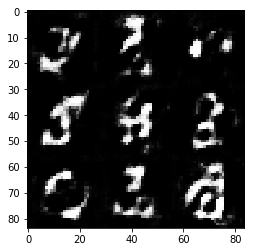

Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 1.1039
Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 0.7125
Epoch 1/2... Discriminator Loss: 1.1778... Generator Loss: 0.7192
Epoch 1/2... Discriminator Loss: 0.8622... Generator Loss: 1.1438
Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 1.7503
Epoch 1/2... Discriminator Loss: 0.9606... Generator Loss: 0.9193
Epoch 1/2... Discriminator Loss: 0.9273... Generator Loss: 1.6102
Epoch 1/2... Discriminator Loss: 0.9697... Generator Loss: 1.2729
Epoch 1/2... Discriminator Loss: 0.9314... Generator Loss: 1.8070
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 2.3738


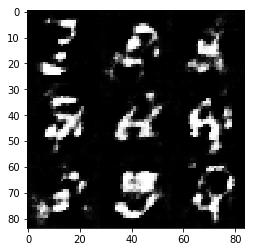

Epoch 1/2... Discriminator Loss: 0.9323... Generator Loss: 0.9004
Epoch 1/2... Discriminator Loss: 0.9457... Generator Loss: 1.6658
Epoch 1/2... Discriminator Loss: 0.8741... Generator Loss: 1.4204
Epoch 1/2... Discriminator Loss: 0.7859... Generator Loss: 1.0638
Epoch 1/2... Discriminator Loss: 0.8812... Generator Loss: 1.3230
Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 1.3526
Epoch 1/2... Discriminator Loss: 0.9256... Generator Loss: 1.5833
Epoch 1/2... Discriminator Loss: 0.8811... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 0.5108
Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 0.9283


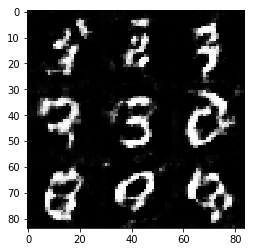

Epoch 1/2... Discriminator Loss: 0.7263... Generator Loss: 1.2438
Epoch 1/2... Discriminator Loss: 0.7750... Generator Loss: 1.2789
Epoch 1/2... Discriminator Loss: 0.8091... Generator Loss: 1.0400
Epoch 1/2... Discriminator Loss: 0.8585... Generator Loss: 0.8534
Epoch 1/2... Discriminator Loss: 0.7768... Generator Loss: 1.0200
Epoch 1/2... Discriminator Loss: 0.8874... Generator Loss: 1.9521
Epoch 1/2... Discriminator Loss: 0.7704... Generator Loss: 1.0287
Epoch 1/2... Discriminator Loss: 0.7326... Generator Loss: 1.6032
Epoch 1/2... Discriminator Loss: 0.7515... Generator Loss: 1.3248
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 2.1642


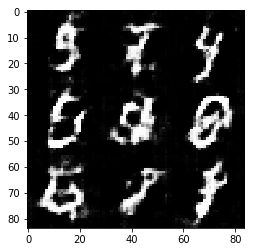

Epoch 1/2... Discriminator Loss: 0.7553... Generator Loss: 1.1257
Epoch 1/2... Discriminator Loss: 0.7665... Generator Loss: 1.2476
Epoch 1/2... Discriminator Loss: 0.8383... Generator Loss: 0.9049
Epoch 1/2... Discriminator Loss: 0.7735... Generator Loss: 1.1623
Epoch 1/2... Discriminator Loss: 1.2112... Generator Loss: 0.5207
Epoch 1/2... Discriminator Loss: 0.9313... Generator Loss: 2.0590
Epoch 1/2... Discriminator Loss: 0.9372... Generator Loss: 0.9840
Epoch 1/2... Discriminator Loss: 0.8796... Generator Loss: 0.8845
Epoch 1/2... Discriminator Loss: 0.7887... Generator Loss: 1.7900
Epoch 1/2... Discriminator Loss: 0.8285... Generator Loss: 1.1332


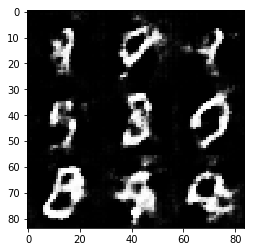

Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 1.9133
Epoch 1/2... Discriminator Loss: 0.9823... Generator Loss: 1.8296
Epoch 1/2... Discriminator Loss: 0.7448... Generator Loss: 1.6147
Epoch 1/2... Discriminator Loss: 0.9293... Generator Loss: 1.5060
Epoch 1/2... Discriminator Loss: 0.8206... Generator Loss: 1.7629
Epoch 1/2... Discriminator Loss: 0.7938... Generator Loss: 1.0671
Epoch 1/2... Discriminator Loss: 0.8081... Generator Loss: 1.1870
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 2.2265
Epoch 1/2... Discriminator Loss: 0.8474... Generator Loss: 1.0078
Epoch 1/2... Discriminator Loss: 0.8539... Generator Loss: 1.0707


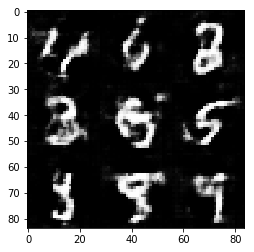

Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 2.2019
Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 1.0070
Epoch 1/2... Discriminator Loss: 0.8049... Generator Loss: 1.3292
Epoch 2/2... Discriminator Loss: 0.8561... Generator Loss: 1.8875
Epoch 2/2... Discriminator Loss: 0.9206... Generator Loss: 0.9173
Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 2.2798
Epoch 2/2... Discriminator Loss: 0.8077... Generator Loss: 1.0497
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 0.8885
Epoch 2/2... Discriminator Loss: 1.1357... Generator Loss: 0.5457
Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 0.9268


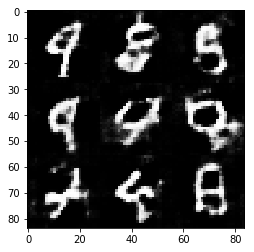

Epoch 2/2... Discriminator Loss: 0.8419... Generator Loss: 1.2458
Epoch 2/2... Discriminator Loss: 0.8746... Generator Loss: 1.0748
Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 0.9004
Epoch 2/2... Discriminator Loss: 1.0175... Generator Loss: 0.9015
Epoch 2/2... Discriminator Loss: 1.0613... Generator Loss: 0.7059
Epoch 2/2... Discriminator Loss: 0.8633... Generator Loss: 1.1449
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 0.9682
Epoch 2/2... Discriminator Loss: 0.7385... Generator Loss: 1.2141
Epoch 2/2... Discriminator Loss: 1.0044... Generator Loss: 0.6679
Epoch 2/2... Discriminator Loss: 1.1876... Generator Loss: 0.5825


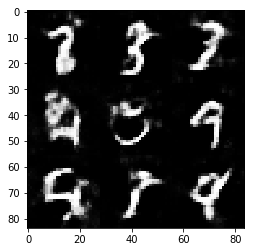

Epoch 2/2... Discriminator Loss: 1.0008... Generator Loss: 0.8222
Epoch 2/2... Discriminator Loss: 0.8831... Generator Loss: 0.9805
Epoch 2/2... Discriminator Loss: 1.0037... Generator Loss: 0.7278
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 2.1867
Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 0.5527
Epoch 2/2... Discriminator Loss: 0.9027... Generator Loss: 1.7124
Epoch 2/2... Discriminator Loss: 0.8756... Generator Loss: 1.3859
Epoch 2/2... Discriminator Loss: 1.3454... Generator Loss: 1.7535
Epoch 2/2... Discriminator Loss: 0.9378... Generator Loss: 0.7925
Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 1.4541


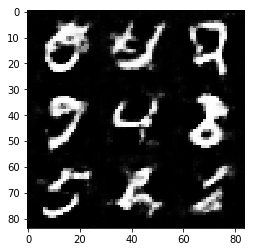

Epoch 2/2... Discriminator Loss: 0.9004... Generator Loss: 1.4819
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 0.4857
Epoch 2/2... Discriminator Loss: 0.8809... Generator Loss: 1.1058
Epoch 2/2... Discriminator Loss: 0.8921... Generator Loss: 0.8680
Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 1.8185
Epoch 2/2... Discriminator Loss: 0.9035... Generator Loss: 1.9050
Epoch 2/2... Discriminator Loss: 0.8545... Generator Loss: 0.9344
Epoch 2/2... Discriminator Loss: 0.8260... Generator Loss: 1.1770
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.0696
Epoch 2/2... Discriminator Loss: 1.0790... Generator Loss: 0.6444


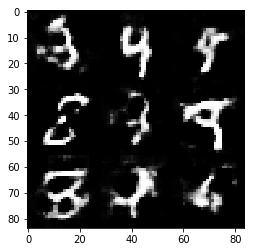

Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 1.0222
Epoch 2/2... Discriminator Loss: 0.8375... Generator Loss: 1.2292
Epoch 2/2... Discriminator Loss: 0.8003... Generator Loss: 1.1981
Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 1.1030
Epoch 2/2... Discriminator Loss: 0.8070... Generator Loss: 1.0645
Epoch 2/2... Discriminator Loss: 1.0809... Generator Loss: 0.6360
Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 2.1160
Epoch 2/2... Discriminator Loss: 0.8260... Generator Loss: 1.2716
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 0.7200
Epoch 2/2... Discriminator Loss: 0.9685... Generator Loss: 1.2290


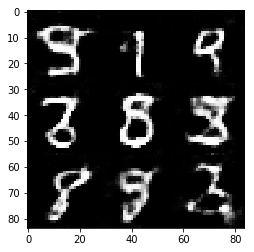

Epoch 2/2... Discriminator Loss: 0.8396... Generator Loss: 1.6870
Epoch 2/2... Discriminator Loss: 0.7192... Generator Loss: 1.3400
Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: 1.7498
Epoch 2/2... Discriminator Loss: 1.0702... Generator Loss: 2.0230
Epoch 2/2... Discriminator Loss: 0.9252... Generator Loss: 0.8554
Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 0.7278
Epoch 2/2... Discriminator Loss: 0.7170... Generator Loss: 1.2614
Epoch 2/2... Discriminator Loss: 0.9277... Generator Loss: 1.4634
Epoch 2/2... Discriminator Loss: 1.1223... Generator Loss: 1.7634
Epoch 2/2... Discriminator Loss: 0.9062... Generator Loss: 1.3468


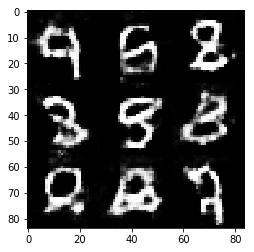

Epoch 2/2... Discriminator Loss: 0.9237... Generator Loss: 1.2773
Epoch 2/2... Discriminator Loss: 0.8832... Generator Loss: 1.4436
Epoch 2/2... Discriminator Loss: 1.0446... Generator Loss: 2.1088
Epoch 2/2... Discriminator Loss: 0.8885... Generator Loss: 0.8894
Epoch 2/2... Discriminator Loss: 1.3132... Generator Loss: 0.4370
Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 0.7030
Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 0.7922
Epoch 2/2... Discriminator Loss: 0.9393... Generator Loss: 1.0858
Epoch 2/2... Discriminator Loss: 0.8513... Generator Loss: 1.6413
Epoch 2/2... Discriminator Loss: 0.8396... Generator Loss: 0.9829


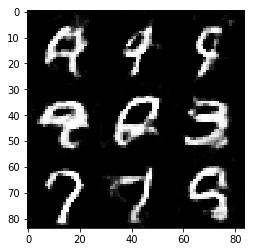

Epoch 2/2... Discriminator Loss: 0.8389... Generator Loss: 0.9736
Epoch 2/2... Discriminator Loss: 1.3408... Generator Loss: 0.4315
Epoch 2/2... Discriminator Loss: 0.7690... Generator Loss: 1.3761
Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 1.2310
Epoch 2/2... Discriminator Loss: 0.8452... Generator Loss: 1.2824
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 2.6342
Epoch 2/2... Discriminator Loss: 0.8322... Generator Loss: 1.0693
Epoch 2/2... Discriminator Loss: 0.7728... Generator Loss: 1.6039
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 0.9687
Epoch 2/2... Discriminator Loss: 0.7925... Generator Loss: 1.2352


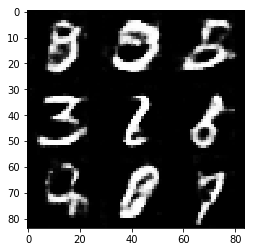

Epoch 2/2... Discriminator Loss: 0.8021... Generator Loss: 1.4062
Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 1.4378
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 1.4419
Epoch 2/2... Discriminator Loss: 1.1107... Generator Loss: 0.5967
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 1.3006
Epoch 2/2... Discriminator Loss: 0.8103... Generator Loss: 1.0782
Epoch 2/2... Discriminator Loss: 0.9903... Generator Loss: 0.6715
Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 1.1478
Epoch 2/2... Discriminator Loss: 0.7630... Generator Loss: 1.5538
Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 1.0000


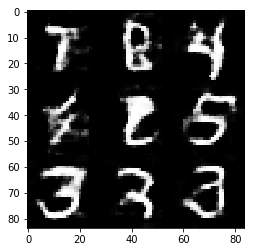

Epoch 2/2... Discriminator Loss: 0.8097... Generator Loss: 1.6764
Epoch 2/2... Discriminator Loss: 0.7963... Generator Loss: 1.0475
Epoch 2/2... Discriminator Loss: 0.8690... Generator Loss: 1.0633
Epoch 2/2... Discriminator Loss: 0.6880... Generator Loss: 1.2231
Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 1.8917
Epoch 2/2... Discriminator Loss: 0.7740... Generator Loss: 1.0863
Epoch 2/2... Discriminator Loss: 1.0121... Generator Loss: 2.4274


In [18]:
batch_size    = 64
z_dim         = 100
learning_rate = 0.0002
beta1         = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 1.8060
Epoch 1/1... Discriminator Loss: 0.0732... Generator Loss: 3.1426
Epoch 1/1... Discriminator Loss: 0.0392... Generator Loss: 3.8818
Epoch 1/1... Discriminator Loss: 0.0410... Generator Loss: 3.8119
Epoch 1/1... Discriminator Loss: 0.1393... Generator Loss: 7.2578
Epoch 1/1... Discriminator Loss: 0.0390... Generator Loss: 3.8627
Epoch 1/1... Discriminator Loss: 0.0271... Generator Loss: 4.4321
Epoch 1/1... Discriminator Loss: 0.0039... Generator Loss: 6.4337
Epoch 1/1... Discriminator Loss: 0.1057... Generator Loss: 5.3427
Epoch 1/1... Discriminator Loss: 0.0710... Generator Loss: 4.2944


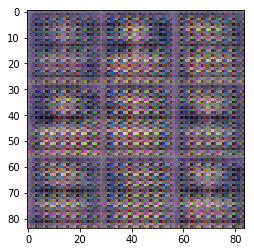

Epoch 1/1... Discriminator Loss: 0.1514... Generator Loss: 2.9764
Epoch 1/1... Discriminator Loss: 0.1896... Generator Loss: 2.9924
Epoch 1/1... Discriminator Loss: 0.1820... Generator Loss: 6.1061
Epoch 1/1... Discriminator Loss: 0.4723... Generator Loss: 1.6110
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 2.2689
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 1.5545
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 2.7116
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 2.0576
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.4975


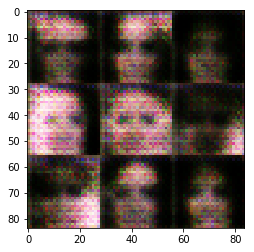

Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 2.5879
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 2.7761
Epoch 1/1... Discriminator Loss: 0.5870... Generator Loss: 2.0523
Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 2.7439


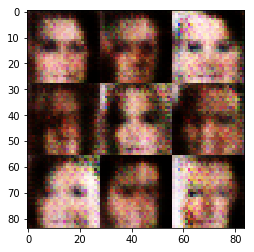

Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 1.6862
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 1.4011
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 2.7872
Epoch 1/1... Discriminator Loss: 0.8772... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 2.3137
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 4.7750
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.6011


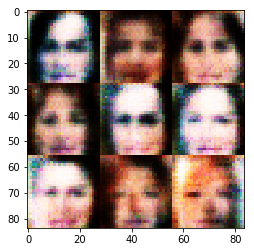

Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 2.5855
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 4.5894
Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 2.1959
Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 3.5094
Epoch 1/1... Discriminator Loss: 0.3776... Generator Loss: 2.1813
Epoch 1/1... Discriminator Loss: 1.6746... Generator Loss: 1.2225
Epoch 1/1... Discriminator Loss: 0.2452... Generator Loss: 3.2770
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 4.5098
Epoch 1/1... Discriminator Loss: 0.2807... Generator Loss: 3.8929


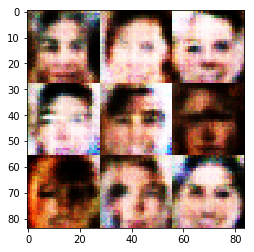

Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 4.7019
Epoch 1/1... Discriminator Loss: 0.2375... Generator Loss: 6.0041
Epoch 1/1... Discriminator Loss: 0.3605... Generator Loss: 4.1440
Epoch 1/1... Discriminator Loss: 0.1892... Generator Loss: 5.2759
Epoch 1/1... Discriminator Loss: 0.1898... Generator Loss: 3.8023
Epoch 1/1... Discriminator Loss: 0.2009... Generator Loss: 4.7326
Epoch 1/1... Discriminator Loss: 0.2687... Generator Loss: 4.4271
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.3854
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 4.0838
Epoch 1/1... Discriminator Loss: 0.6393... Generator Loss: 4.9853


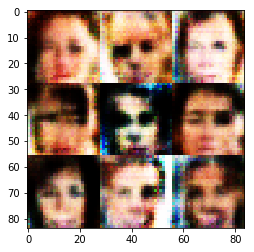

Epoch 1/1... Discriminator Loss: 0.2811... Generator Loss: 3.6095
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 3.3206
Epoch 1/1... Discriminator Loss: 0.6352... Generator Loss: 6.2868
Epoch 1/1... Discriminator Loss: 0.3471... Generator Loss: 4.2430
Epoch 1/1... Discriminator Loss: 0.2981... Generator Loss: 3.8371
Epoch 1/1... Discriminator Loss: 0.3045... Generator Loss: 2.6771
Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 5.9629
Epoch 1/1... Discriminator Loss: 0.3349... Generator Loss: 6.6228
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 5.9869
Epoch 1/1... Discriminator Loss: 0.2963... Generator Loss: 3.4132


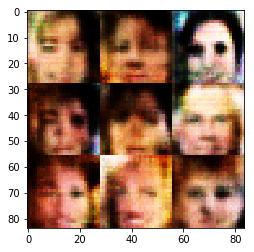

Epoch 1/1... Discriminator Loss: 0.2109... Generator Loss: 4.9603
Epoch 1/1... Discriminator Loss: 0.2739... Generator Loss: 3.1798
Epoch 1/1... Discriminator Loss: 0.1746... Generator Loss: 3.9469
Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 7.9915
Epoch 1/1... Discriminator Loss: 0.2342... Generator Loss: 4.2490
Epoch 1/1... Discriminator Loss: 0.1770... Generator Loss: 4.7496
Epoch 1/1... Discriminator Loss: 0.2904... Generator Loss: 3.4609
Epoch 1/1... Discriminator Loss: 0.1545... Generator Loss: 4.5550
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 7.7611
Epoch 1/1... Discriminator Loss: 0.2345... Generator Loss: 3.8857


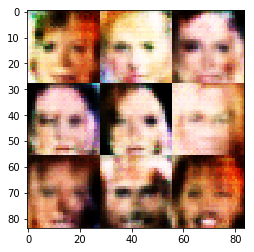

Epoch 1/1... Discriminator Loss: 0.2894... Generator Loss: 3.1453
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 3.2027
Epoch 1/1... Discriminator Loss: 0.4365... Generator Loss: 2.3609
Epoch 1/1... Discriminator Loss: 0.3742... Generator Loss: 3.7468
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 3.4882
Epoch 1/1... Discriminator Loss: 0.2002... Generator Loss: 6.5428
Epoch 1/1... Discriminator Loss: 0.3772... Generator Loss: 4.0677
Epoch 1/1... Discriminator Loss: 0.4683... Generator Loss: 6.0355
Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 2.1078
Epoch 1/1... Discriminator Loss: 0.1901... Generator Loss: 6.5181


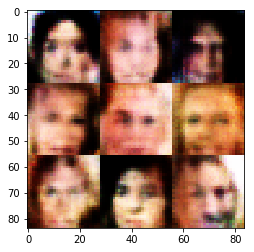

Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 0.4372... Generator Loss: 3.3249
Epoch 1/1... Discriminator Loss: 0.3325... Generator Loss: 3.2171
Epoch 1/1... Discriminator Loss: 0.3005... Generator Loss: 3.0865
Epoch 1/1... Discriminator Loss: 0.2225... Generator Loss: 4.3586
Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 4.3191
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 3.1827
Epoch 1/1... Discriminator Loss: 0.2062... Generator Loss: 4.5398
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 3.3772
Epoch 1/1... Discriminator Loss: 0.3095... Generator Loss: 4.0567


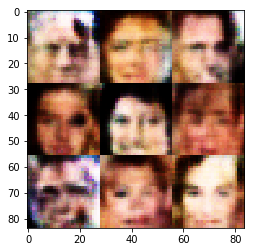

Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.9946
Epoch 1/1... Discriminator Loss: 0.2663... Generator Loss: 5.5910
Epoch 1/1... Discriminator Loss: 0.5118... Generator Loss: 2.2263
Epoch 1/1... Discriminator Loss: 0.6289... Generator Loss: 3.0757
Epoch 1/1... Discriminator Loss: 0.1783... Generator Loss: 5.7468
Epoch 1/1... Discriminator Loss: 0.5537... Generator Loss: 5.1226
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 2.7956
Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 2.5037
Epoch 1/1... Discriminator Loss: 0.2372... Generator Loss: 5.5215
Epoch 1/1... Discriminator Loss: 0.2462... Generator Loss: 3.5167


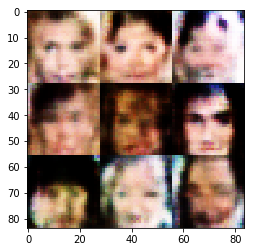

Epoch 1/1... Discriminator Loss: 0.4180... Generator Loss: 3.0397
Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 2.5500
Epoch 1/1... Discriminator Loss: 0.4167... Generator Loss: 2.7088
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 5.1856
Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 1.9713
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 3.0118
Epoch 1/1... Discriminator Loss: 0.2982... Generator Loss: 4.8162
Epoch 1/1... Discriminator Loss: 0.2898... Generator Loss: 3.7016
Epoch 1/1... Discriminator Loss: 0.2568... Generator Loss: 4.4755
Epoch 1/1... Discriminator Loss: 0.4992... Generator Loss: 2.9703


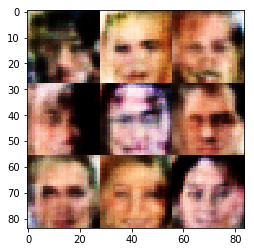

Epoch 1/1... Discriminator Loss: 0.1128... Generator Loss: 7.7857
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 5.6860
Epoch 1/1... Discriminator Loss: 0.3016... Generator Loss: 4.9672
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 3.0169
Epoch 1/1... Discriminator Loss: 0.3008... Generator Loss: 2.9850
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 2.6939
Epoch 1/1... Discriminator Loss: 0.1992... Generator Loss: 5.6531
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 1.5160
Epoch 1/1... Discriminator Loss: 0.1641... Generator Loss: 5.7326
Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 3.4726


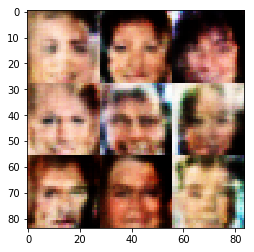

Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 1.8641
Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 2.9454
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 4.1658
Epoch 1/1... Discriminator Loss: 0.5078... Generator Loss: 2.2204
Epoch 1/1... Discriminator Loss: 0.2949... Generator Loss: 5.0050
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 2.9978
Epoch 1/1... Discriminator Loss: 0.3679... Generator Loss: 2.6350
Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 2.2752
Epoch 1/1... Discriminator Loss: 0.5458... Generator Loss: 2.2504


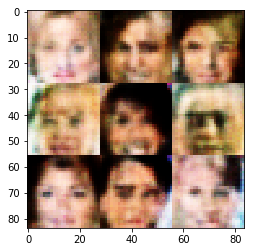

Epoch 1/1... Discriminator Loss: 0.1806... Generator Loss: 5.3015
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 2.9031
Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 3.1362
Epoch 1/1... Discriminator Loss: 0.3326... Generator Loss: 3.3623
Epoch 1/1... Discriminator Loss: 0.6100... Generator Loss: 3.3697
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 3.8089
Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 3.7464
Epoch 1/1... Discriminator Loss: 0.2215... Generator Loss: 6.9319
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 5.7016
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 4.5298


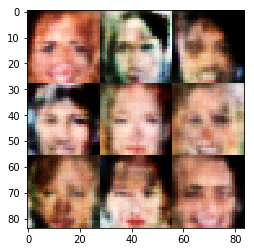

Epoch 1/1... Discriminator Loss: 0.2993... Generator Loss: 4.2885
Epoch 1/1... Discriminator Loss: 0.1831... Generator Loss: 4.2741
Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 4.2315
Epoch 1/1... Discriminator Loss: 0.2749... Generator Loss: 3.0513
Epoch 1/1... Discriminator Loss: 0.3024... Generator Loss: 4.5053
Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 2.0245
Epoch 1/1... Discriminator Loss: 0.2546... Generator Loss: 5.7594
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 2.1173
Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 2.4038
Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 2.1488


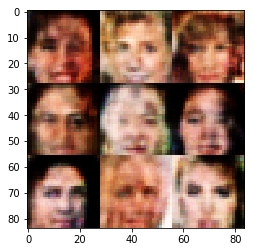

Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 1.5728
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 2.4570
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 2.0741
Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 2.2868
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 1.6677
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 2.0567
Epoch 1/1... Discriminator Loss: 0.6866... Generator Loss: 4.6011
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 2.3670
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 1.8829


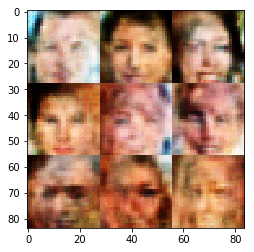

Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 2.7881
Epoch 1/1... Discriminator Loss: 0.3096... Generator Loss: 3.4591
Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 3.2112
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 1.8950
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 1.3575
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 1.7779
Epoch 1/1... Discriminator Loss: 0.2944... Generator Loss: 5.1039
Epoch 1/1... Discriminator Loss: 0.2425... Generator Loss: 4.3374
Epoch 1/1... Discriminator Loss: 0.4514... Generator Loss: 2.6275


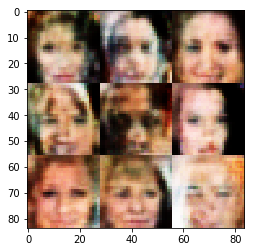

Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 2.8896
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 4.3578
Epoch 1/1... Discriminator Loss: 0.4233... Generator Loss: 2.9691
Epoch 1/1... Discriminator Loss: 0.6563... Generator Loss: 1.6059
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 3.4763
Epoch 1/1... Discriminator Loss: 0.2543... Generator Loss: 5.6751
Epoch 1/1... Discriminator Loss: 0.3921... Generator Loss: 2.8404
Epoch 1/1... Discriminator Loss: 0.4883... Generator Loss: 2.0736
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 4.4562
Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 2.9695


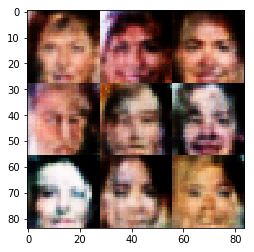

Epoch 1/1... Discriminator Loss: 0.1929... Generator Loss: 5.8634
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 2.5283
Epoch 1/1... Discriminator Loss: 0.2654... Generator Loss: 3.7905
Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 1.8931
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 2.2041
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 2.5992
Epoch 1/1... Discriminator Loss: 0.4494... Generator Loss: 2.1447
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 1.3542
Epoch 1/1... Discriminator Loss: 0.6617... Generator Loss: 5.9894
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.8971


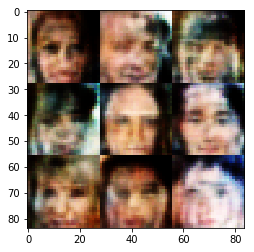

Epoch 1/1... Discriminator Loss: 0.3765... Generator Loss: 2.2413
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 1.2006
Epoch 1/1... Discriminator Loss: 0.3908... Generator Loss: 2.2156
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.5558
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 2.7030
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 1.2805
Epoch 1/1... Discriminator Loss: 0.3663... Generator Loss: 2.2782
Epoch 1/1... Discriminator Loss: 0.3292... Generator Loss: 3.1795


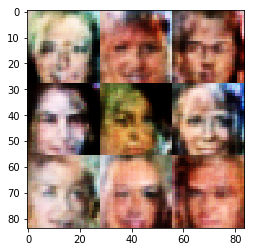

Epoch 1/1... Discriminator Loss: 0.2708... Generator Loss: 7.3074
Epoch 1/1... Discriminator Loss: 0.2663... Generator Loss: 4.0135
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 7.3630
Epoch 1/1... Discriminator Loss: 0.5326... Generator Loss: 1.4963
Epoch 1/1... Discriminator Loss: 0.3429... Generator Loss: 3.0207
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 2.6166
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 2.6524
Epoch 1/1... Discriminator Loss: 0.3202... Generator Loss: 3.0621
Epoch 1/1... Discriminator Loss: 0.6379... Generator Loss: 1.5696
Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 1.7738


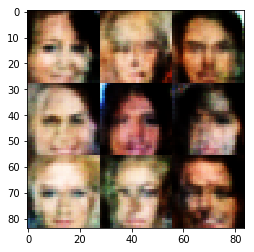

Epoch 1/1... Discriminator Loss: 0.2936... Generator Loss: 4.4022
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 1.9740
Epoch 1/1... Discriminator Loss: 0.3076... Generator Loss: 3.1757
Epoch 1/1... Discriminator Loss: 0.7189... Generator Loss: 1.3919
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.0569
Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 0.2131... Generator Loss: 4.7177
Epoch 1/1... Discriminator Loss: 0.3237... Generator Loss: 4.3164
Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 2.8508
Epoch 1/1... Discriminator Loss: 0.4468... Generator Loss: 3.8130


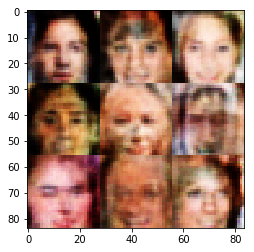

Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 3.1883
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 0.2996... Generator Loss: 3.8806
Epoch 1/1... Discriminator Loss: 0.4609... Generator Loss: 2.3020
Epoch 1/1... Discriminator Loss: 0.4739... Generator Loss: 2.7268
Epoch 1/1... Discriminator Loss: 0.4270... Generator Loss: 3.4954
Epoch 1/1... Discriminator Loss: 0.2451... Generator Loss: 3.1621
Epoch 1/1... Discriminator Loss: 0.2938... Generator Loss: 3.4296
Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 6.1718
Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 1.2348


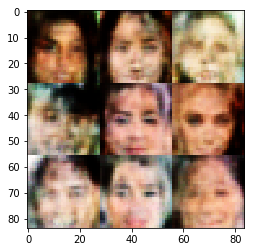

Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 2.3151
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 2.2730
Epoch 1/1... Discriminator Loss: 0.0685... Generator Loss: 10.0048
Epoch 1/1... Discriminator Loss: 0.2844... Generator Loss: 4.5151
Epoch 1/1... Discriminator Loss: 0.5189... Generator Loss: 1.8925
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 2.5074
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 2.1068
Epoch 1/1... Discriminator Loss: 0.2837... Generator Loss: 3.5845
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 1.8936
Epoch 1/1... Discriminator Loss: 0.5842... Generator Loss: 2.7752


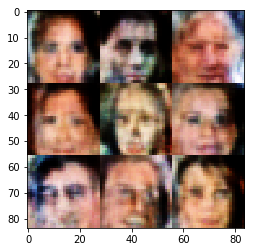

Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 2.9640
Epoch 1/1... Discriminator Loss: 0.4148... Generator Loss: 2.3529
Epoch 1/1... Discriminator Loss: 0.6128... Generator Loss: 2.7898
Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 3.9337
Epoch 1/1... Discriminator Loss: 0.4612... Generator Loss: 3.0943
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 0.5173... Generator Loss: 3.4013
Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 1.7709
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 1.6013
Epoch 1/1... Discriminator Loss: 0.2335... Generator Loss: 5.6502


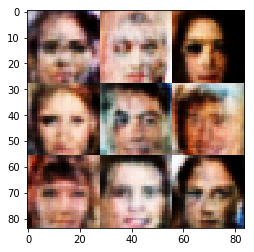

KeyboardInterrupt: 

In [ ]:
batch_size    = 64
z_dim         = 100
learning_rate = 0.0002
beta1         = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.